# COMP5318 ASSIGNMENT 2: OTHER ALGORITHMS

**GROUP 144:**
- Aryan Bhatia : 490352056
- Mudit Malhotra : 490583269

**REFERENCES:**
- https://towardsdatascience.com/multithreading-and-multiprocessing-in-10-minutes-20d9b3c6a867

## IMPROVING PERFORMACE USING PARALLELIZATION

In this notebook you will see the use of python's `joblib` library for the purpose of **Multi-threading** while training models. We have also implemented **Multi-Processing** during parameter tuning by setting the value `n_jobs` parameter of `GridSearchCV` as 1. This instructs GridSearch to use all the cores of the system while performing cross validation to find the best parameters for the classifer. 

### Multi-threading v/s Multi-processing
- **Multi-Threading** is the ability of a **processor** to execute multiple threads concurrently where each thread runs a process. 
- **Multi-processing** is the ability of a **system** (CPU) to run multiple processors (cores) concurrently where each processor can run one or more threads. 

## IMPORTING CLEAN DATA & LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Make the notebook's output stable across runs
np.random.seed(42)

# multi-threading
from joblib import parallel_backend

# models 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# evaluation
from sklearn import metrics

# parameter tuning 
from sklearn.model_selection import GridSearchCV

# getting the data
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test

X_train = X_train.toarray()
X_test  = X_test.toarray()
y_train = np.array(y_train)
y_test  = np.array(y_test)

# Reducing Number of Datapoints for better model training times
X_train = np.resize(X_train, (100000, 1000))
y_train = np.resize(y_train, (100000,))
X_test  = np.resize(X_test, (42000, 1000))
y_test  = np.resize(y_test, (42000,))

# Note: After the resizing above, it is still a stratified 70-30 train-test split

In [18]:
# Helper Function for evaluation 
def evaluate(y_test, y_predict, model):
    print("\nMODEL: " + str(model))
    print('Accuracy: ', metrics.accuracy_score(y_test, y_predict))
    print("Precision: ", metrics.precision_score(y_test, y_predict))
    print("Recall: ", metrics.recall_score(y_test, y_predict))
    print("F1 Score: ", metrics.f1_score(y_test, y_predict))
    print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, y_predict))
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict)
    auc = metrics.roc_auc_score(y_test, y_predict)

    # Plot ROC for this label
    plt.plot(fpr,tpr,label="AUC = "+ "{:.2f}".format(auc))
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

## Naive Bayes

Chose Multinomial NB since it works the best for multinomial distribution with discrete features. Infact, the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) mention tf-idf which is what we have applied. 

### DEFAULT

In [19]:
%%time
nb = MultinomialNB()

with parallel_backend('threading'):
    nb.fit(X_train, y_train)

CPU times: user 379 ms, sys: 11.9 ms, total: 391 ms
Wall time: 190 ms



MODEL: Multinomial Naive Bayes
Accuracy:  0.720452380952381
Precision:  0.728093858917088
Recall:  0.7051440524864505
F1 Score:  0.7164352131385098
Confusion Matrix: 
 [[15427  5539]
 [ 6202 14832]]


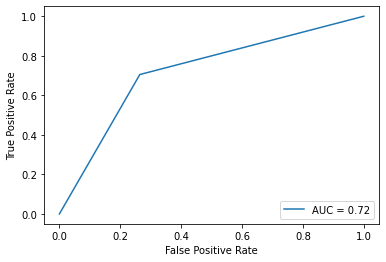

In [20]:
y_predict = nb.predict(X_test)
evaluate(y_test, y_predict, 'Multinomial Naive Bayes')

### PARAMETER TUNING

In [5]:
alpha_vals = []

start = 0.5
while start < 10:
    alpha_vals.append(start)
    start += 0.5

start = 10
while start < 100:
    alpha_vals.append(start)
    start += 10

start = 100
while start <= 1000:
    alpha_vals.append(start)
    start += 100

Fitting 5 folds for each of 38 candidates, totalling 190 fits
Best parameters:  {'alpha': 20}

MODEL: Multinomial Naive Bayes + GridSearchCV
Accuracy:  0.7203809523809523
Precision:  0.7286375270722584
Recall:  0.7037653323191024
F1 Score:  0.7159854897218862
Confusion Matrix: 
 [[15453  5513]
 [ 6231 14803]]


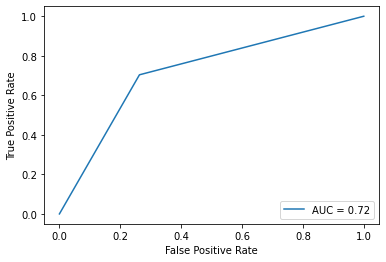

In [26]:
gridsearch_nb = GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': alpha_vals},
             verbose=1, n_jobs=-1)

gridsearch_nb.fit(X_train, y_train)

print("Best parameters: ", gridsearch_nb.best_params_)

y_predict = gridsearch_nb.predict(X_test)
evaluate(y_test, y_predict, 'Multinomial Naive Bayes + GridSearchCV')

As seen above, GridSearchCV is actually reducing the accuracy of our model compared to default. This is because, GridSearchCV only considers the training set and performs cross validation on it to find the best model. GridSearchCV is the right approach considering that it doesn't take the test data into account at all so it gives the best parameters (based on training data) that would perform the best on a blind dataset. In most cases this approach gives us a model that performs better on the test dataset as well but that hasn't been the case here which is fine. However, if we want to find the model that would perform the best on the test set, we can write a simple manual script as seen below. 

In [7]:
best_alpha = 0
best_acc   = 0

for alpha in alpha_vals:
    curr_nb       = MultinomialNB(alpha=alpha).fit(X_train, y_train)
    y_pred        = curr_nb.predict(X_test) 
    curr_accuracy = metrics.accuracy_score(y_test, y_pred)
    if curr_accuracy > best_acc:
        best_alpha = alpha
        best_acc   = curr_accuracy


MODEL: Multinomial Naive Bayes + Best Alpha (Using Manual Script)
Accuracy:  0.7208809523809524
Precision:  0.7285356634431299
Recall:  0.7055719311590758
F1 Score:  0.7168699432435696
Confusion Matrix: 
 [[15436  5530]
 [ 6193 14841]]


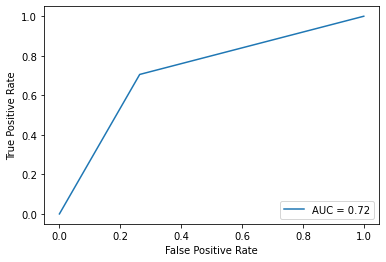

In [25]:
nb = MultinomialNB(alpha=best_alpha)

with parallel_backend('threading'):
    nb.fit(X_train, y_train)

y_predict = nb.predict(X_test)
evaluate(y_test, y_predict, 'Multinomial Naive Bayes + Best Alpha (Using Manual Script)')

## Logistic Regression

### DEFAULT

In [22]:
%%time
lr = LogisticRegression()

with parallel_backend('threading'):
    lr.fit(X_train, y_train)

CPU times: user 44.2 s, sys: 1.27 s, total: 45.5 s
Wall time: 8.04 s



MODEL: Logistic Regression
Accuracy:  0.7328095238095238
Precision:  0.7165430790960452
Recall:  0.7717980412665209
F1 Score:  0.7431448844129092
Confusion Matrix: 
 [[14544  6422]
 [ 4800 16234]]


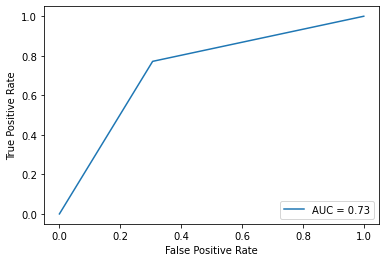

In [23]:
y_predict = lr.predict(X_test)
evaluate(y_test, y_predict, 'Logistic Regression')

### PARAMETER TUNING

In [ ]:
param_grid_lr = {
    'C': [100.0, 10.0, 1.0, 0.1, 0.01],
    'solver': ['sag', 'saga', 'liblinear', 'newton-cg', 'lbfgs'],
    'penalty': ['l1', 'l2', 'elasticnet', 'none']
}
gridsearch_lr = GridSearchCV(estimator=LogisticRegression(),
             param_grid=param_grid_lr, verbose=1, n_jobs=-1)

gridsearch_lr.fit(X_train, y_train)

Best parameters:  {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}

MODEL: Logistic Regression + GridSearchCV
Accuracy:  0.7334047619047619
Precision:  0.7158278116635218
Recall:  0.775553865170676
F1 Score:  0.7444948999383885
Confusion Matrix: 
 [[14490  6476]
 [ 4721 16313]]


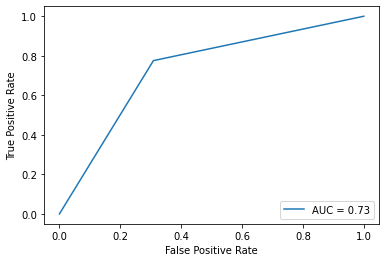

In [24]:
print("Best parameters: ", gridsearch_lr.best_params_)

y_predict = gridsearch_lr.predict(X_test)
evaluate(y_test, y_predict, 'Logistic Regression + GridSearchCV')

## Long Short Term Memory Model (LSTM)